In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from pandas import read_csv
from tqdm import tqdm
from scipy.integrate import quad
from scipy.differentiate import derivative
from scipy.signal import argrelmax, argrelmin
from scipy.interpolate import interp1d
import os

### Simulation and analysis code properties

In [5]:
#Conversion in IU
G_p = 6.67259e-8 #G in cgs
M_sun = 1.9891e33 #solar mass in g
R_sun = 6.9598e10 #solar radius in cm 
year = 3.14159e7
ly = 9.463e17 #light year in cm
parsec = 3.086e18 #parsec in cm
AU = 1.496e13 #astronomical unit in cm

def v_IU(v_p, M_p=M_sun, r_p=AU):
    return np.sqrt(r_p / (G_p * M_p)) * v_p

def t_IU(t_p, M_p=M_sun, r_p=AU):
    return t_p / (np.sqrt(r_p / (G_p * M_p)) * r_p)

r_phy = parsec
M_phy = M_sun
t_iu_phy = t_IU(year, M_phy, r_phy) #1 yr is 6.251839 IU
v_iu_phy = v_IU(1, M_phy, r_phy) #1 cm/s is 3.357e-7 IU

In [6]:
N = 10000 #Number of particles
M = 10000 #Total mass in 1e6 solar masses
b = 1  #Total radius in parsec
m_i = M / N #Particle mass in solar masses
mass_populations = False #True to use the simulation with two mass populations
display_animation = True #True to display the distribution 3D animation
save_plots = False #True to save all generated plots

#Relative path of the generated file
if mass_populations:
    path = "MS/PR_N" + str(N) + "_M" + str(int(M)) + "_b" + str(b)
    
else:
    path = "SP/PR_N" + str(N) + "_M" + str(int(M)) + "_b" + str(b)

sim_file = "Output/" + path + ".out" #Simulation output file path
save_path = "Figures/" + path + "/" #Path to save all plots to, if enabled

In [7]:
#Define the folder where all figures are saved
if save_plots:
    distdir = os.getcwd()
    distname = save_path  
    distot = os.path.join(distdir, distname)
    
    #If the directory doesn't exist, create it
    if not os.path.exists(distot):
        os.makedirs(distot) 

### Functions to read data from simulation output file

In [9]:
#Function that reads the simulation data from the output file
def GetData(filename, N):
    #Get data in a pandas dataframe
    data = read_csv(filename, 
                    names=["x", "y", "z"],
                    sep="\s+")
    
    #Get the simulation time (first column of the corresponding rows)
    time = np.array(data[2::3*N + 3])[:, 0]
    
    #Get the particle masses
    m = np.array(data[3:N+3])[:, 0]

    #Remove the rows corresponding to N and time (which are padded with NaNs)
    data = data.dropna().reset_index(drop=True)
    
    #Get the particle coordinates and velocities in the external frame
    #Rows are the evolution in time of a given particle, columns are the particle
    #number, and the third dimension are its coordinates/velocities
    pos_ext = np.array([data[i::2*N] for i in range(N)]).transpose(1, 0, 2)
    vel_ext = np.array([data[i+N::2*N] for i in range(N)]).transpose(1, 0, 2)
    
    #Compute CM position ad velocity
    CM_p = np.array([np.sum(m * pos_ext[:, :, i], axis=1) for i in range(3)]).T / M
    CM_v = np.array([np.sum(m * vel_ext[:, :, i], axis=1) for i in range(3)]).T / M

    #Convert from external to CM frame
    pos_CM = pos_ext.copy()
    vel_CM = vel_ext.copy()
    
    for i in range(CM_p.shape[0]):
        pos_CM[i, :, :] -= CM_p[i, :]
        vel_CM[i, :, :] -= CM_v[i, :]
    
    return time, m, pos_ext, vel_ext, pos_CM, vel_CM, CM_p, CM_v


#Function that reads the data from the log file
def GetLogData(filename): 
    with open(filename, "r") as log_file:
        output = np.array(log_file.read().splitlines())    
        idx = np.where(output == output[9])[0] #Find the row with T and U
    
    E_tot = np.zeros(len(idx))
    K_tot = np.zeros(len(idx))    
    U_tot = np.zeros(len(idx))   
        
    for i, j in enumerate(idx):
        E_tot[i] = float(output[j + 1].split()[0])
        K_tot[i] = float(output[j + 1].split()[1])
        U_tot[i] = -float(output[j + 1].split()[2])
    
    return K_tot, U_tot, E_tot

### Get data from simulation output

In [11]:
#Get the simulation time and the positions and velocities of the particles
time_all, masses, pos_ext_all, vel_ext_all, pos_CM_all, vel_CM_all, CM_p_all, CM_v_all = GetData(sim_file, N)

In [12]:
#Only read data up to index "stop_idx"
if mass_populations:
    stop = int(len(time_all) * 0.4)

else:
    stop = int(len(time_all) * 0.828)
    
thin = 1
    
time = time_all[:stop:thin]
pos_ext = pos_ext_all[:stop:thin, :, :]
vel_ext = vel_ext_all[:stop:thin, :, :]
pos_CM = pos_CM_all[:stop:thin, :, :]
vel_CM = vel_CM_all[:stop:thin, :, :]
CM_p = CM_p_all[:stop:thin, :]
CM_v = CM_v_all[:stop:thin, :]

#Time in years
time_yr = time / t_iu_phy

#Positions and velocities of the particles in the external frame
x_ext, y_ext, z_ext = pos_ext[:, :, 0], pos_ext[:, :, 1], pos_ext[:, :, 2]
vx_ext, vy_ext, vz_ext = vel_ext[:, :, 0], vel_ext[:, :, 1], vel_ext[:, :, 2]

R_ext = np.sqrt(np.sum(pos_ext**2, axis=2))
V_ext = np.sqrt(np.sum(vel_ext**2, axis=2))
            
#Positions and velocities of the particles in the CM frame
x_CM, y_CM, z_CM = pos_CM[:, :, 0], pos_CM[:, :, 1], pos_CM[:, :, 2]
vx_CM, vy_CM, vz_CM = vel_CM[:, :, 0], vel_CM[:, :, 1], vel_CM[:, :, 2]

R_CM = np.sqrt(np.sum(pos_CM**2, axis=2))
V_CM = np.sqrt(np.sum(vel_CM**2, axis=2))

#Position and velocity of CM in the external frame
CM_x, CM_y, CM_z = CM_p[:, 0], CM_p[:, 1], CM_p[:, 2]
CM_vx, CM_vy, CM_vz = CM_v[:, 0], CM_v[:, 1], CM_v[:, 2]

CM_R = np.sqrt(np.sum(CM_p**2, axis=1))
CM_V = np.sqrt(np.sum(CM_v**2, axis=1))

#Indices for light and heavy particles
light_idx = np.where(masses == np.min(masses))[0]

if mass_populations:
    heavy_idx = np.where(masses == np.max(masses))[0]

### Compute theoretical timescales

In [14]:
#Compute the dynamical time in years
density_0 = M * M_phy / (4/3 * np.pi * (np.median(R_CM[0, :]) * r_phy)**3)
t_dyn = np.sqrt(3 * np.pi / (16 * G_p * density_0)) / year

#Compute relaxation timescale
t_rel = t_dyn * N / (8 * np.log(N))

print("Dynamical time: t_dyn =" + f"{t_dyn: .3e}" + " yr =" + f"{t_dyn * t_iu_phy: .3e}" + " IU")
print("Global relaxation time: t_rel =" + f"{t_rel: .3e}" + " yr =" + f"{t_rel * t_iu_phy: .3e}" + " IU")
print("Initial mean density = " + f"{density_0: .3e}" + " g cm^-3")

Dynamical time: t_dyn = 3.516e+05 yr = 2.348e-02 IU
Global relaxation time: t_rel = 4.772e+07 yr = 3.186e+00 IU
Initial mean density =  7.234e-20 g cm^-3


### Cluster animation and top-down view

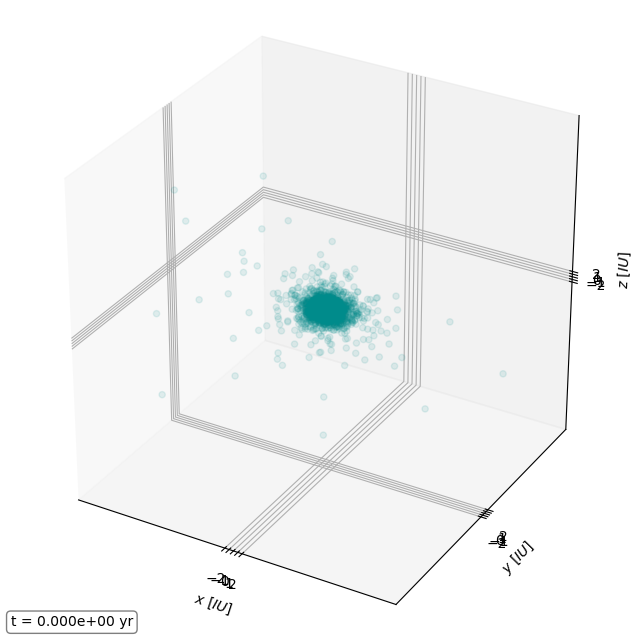

In [53]:
if display_animation:    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection="3d")
    ax.set_aspect("equal")
    
    ticks = np.linspace(-2, 2., 5)
    bbox = dict(boxstyle='round', fc='white', ec='black', alpha=0.5)

    #IDs of heavy and light particles
    massive_idx = np.where(masses == np.max(masses))[0]
    light_idx = np.where(masses == np.min(masses))[0]
    
    def update_anim(frame):
        ax.clear()
        
        ax.set_autoscale_on(False)
        ax.scatter(x_CM[frame, light_idx], y_CM[frame, light_idx], z_CM[frame, light_idx], alpha=0.1, color="darkcyan")

        #Add heavy particles
        if mass_populations:
            ax.scatter(x_CM[frame, heavy_idx], y_CM[frame, heavy_idx], z_CM[frame, heavy_idx], alpha=0.9, color="crimson")
            
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_zticks(ticks)
        ax.set_xlabel("$x\ [IU]$", size=10)
        ax.set_ylabel("$y\ [IU]$", size=10)
        ax.set_zlabel("$z\ [IU]$", size=10)
        ax.set_xlim(-np.max(x_CM[0, :]), np.max(x_CM[0, :]))
        ax.set_ylim(-np.max(y_CM[0, :]), np.max(y_CM[0, :]))
        ax.set_zlim(-np.max(z_CM[0, :]), np.max(z_CM[0, :]))
        ax.text(0.875, 0.04, 0., s="t =" + f"{time_yr[frame]: .3e}" + " yr", bbox=bbox, color="black", size=10, transform=ax.transAxes)

    end = np.where(time == max(time))[0][0]
    animation = anim.FuncAnimation(fig=fig, 
                                   func=update_anim, 
                                   frames=end, 
                                   interval=20, repeat=True)
    
    if save_plots:
        animation.save(save_path + "Sim_anim.gif", progress_callback = lambda i, n: print(f"Saving frame {i}/{n}"))

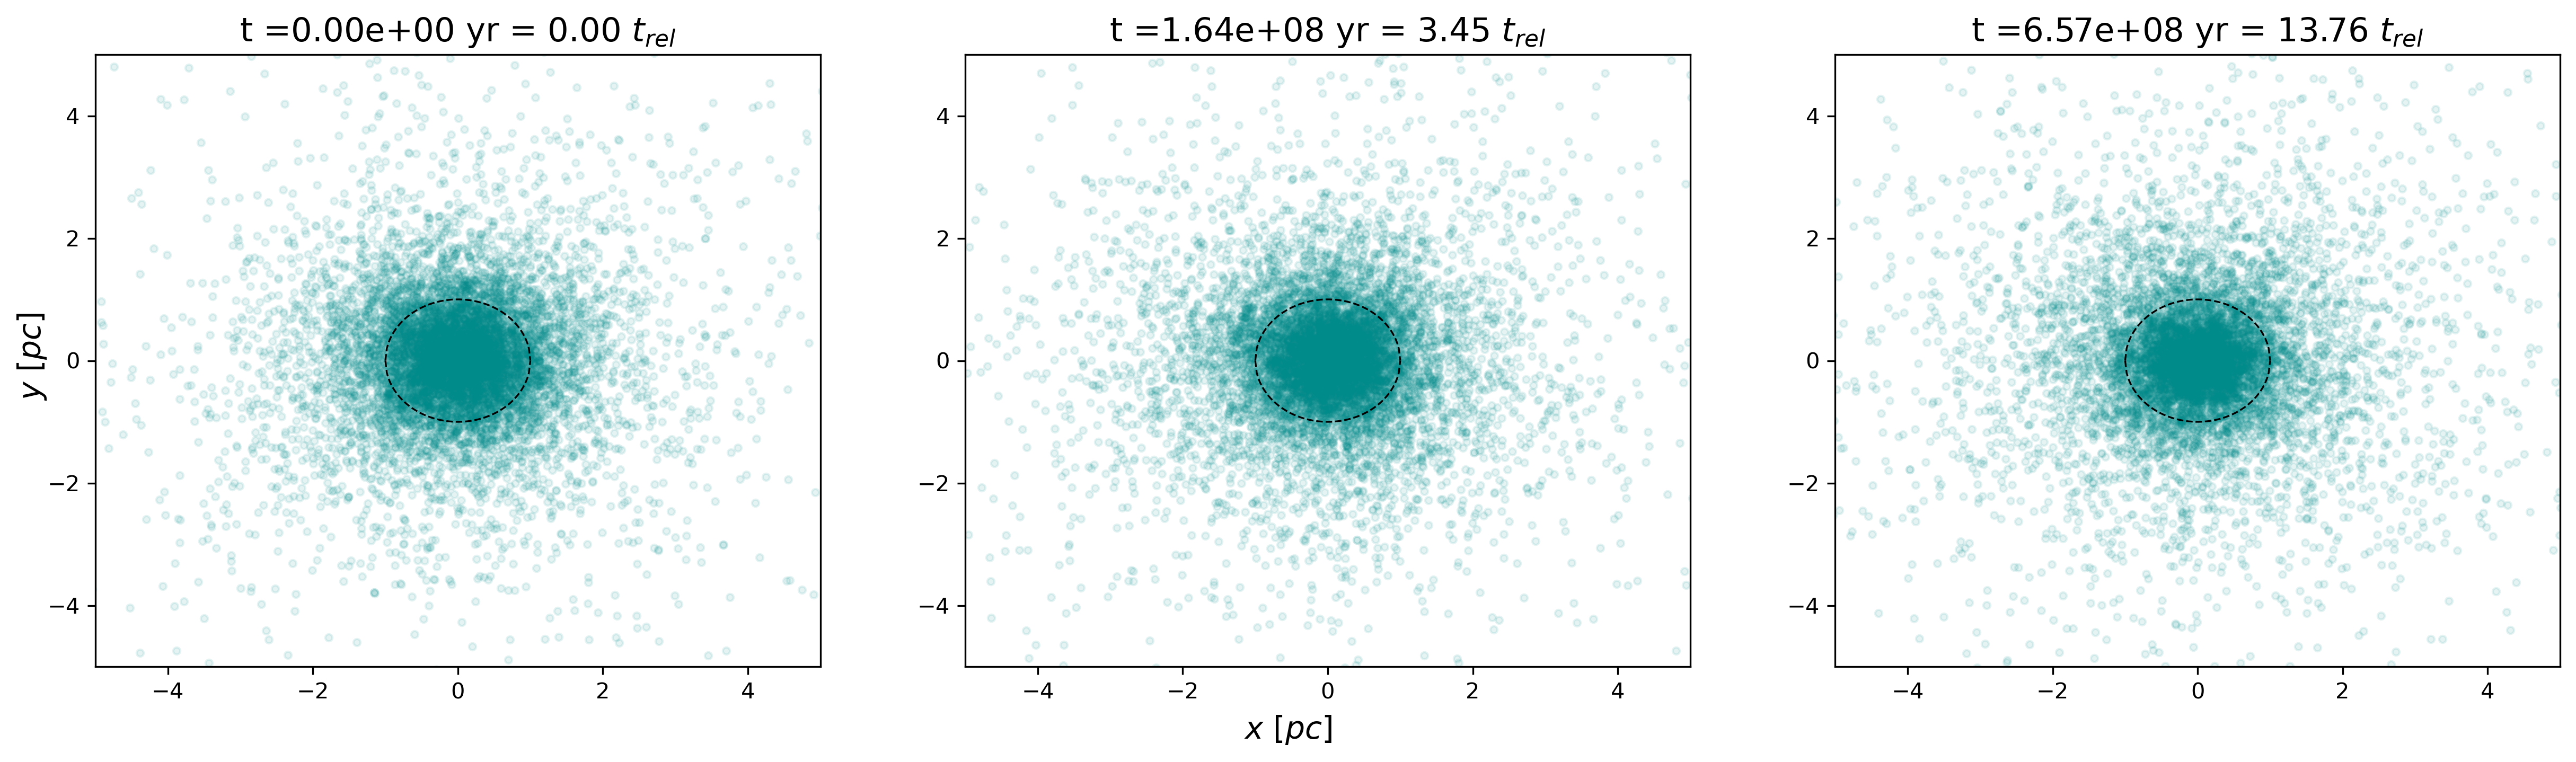

In [38]:
#Top-down view of the system
fig_ms, ax_ms = plt.subplots(1, 3, figsize=(20, 5), dpi=300)
bbox = dict(boxstyle='round', fc='white', ec='black', alpha=0.5)

for i, t in enumerate([0, int(len(time)/4), -1]):
    ax_ms[i].scatter(x_CM[t, light_idx], y_CM[t, light_idx], alpha=0.1, s=10.1, color="darkcyan")
    
    if mass_populations:
        ax_ms[i].scatter(x_CM[t, heavy_idx], y_CM[t, heavy_idx], alpha=0.6, s=13, color="darkblue")
        ax_ms[i].scatter(x_CM[t, heavy_idx][R_CM[t, heavy_idx] <= b], y_CM[t, heavy_idx][R_CM[t, heavy_idx] <= b], alpha=1, s=13, color="crimson")
        
    ax_ms[i].plot(np.linspace(-b, b, 100), np.sqrt(b**2 - np.linspace(-b, b, 100)**2), color="black", ls="--", lw=0.8)
    ax_ms[i].plot(np.linspace(-b, b, 100), -np.sqrt(b**2 - np.linspace(-b, b, 100)**2), color="black", ls="--", lw=0.8)    
    ax_ms[i].set_xlim(-5, 5)
    ax_ms[i].set_ylim(-5, 5)
    ax_ms[i].set_title("t =" + f"{time_yr[t]:.2e}" + " yr = " + f"{time_yr[t] / t_rel:.2f}" + " $t_{rel}$", size=15)
    
    if mass_populations:
        ax_ms[i].text(0.67, 0.8, s="$f_{heavy}^{< b} = " + str(np.sum(R_CM[t, heavy_idx] <= b) / len(heavy_idx)) + "$" + "\n" + "$" + "f_{light}^{< b} = " + f"{np.sum(R_CM[t, light_idx] <= b) / len(light_idx): .2f}" + "$", bbox=bbox, color="black", size=17, transform=ax_ms[i].transAxes)
    
fig_ms.supxlabel("$x\ [pc]$", size=14)
fig_ms.supylabel("$y\ [pc]$", size=14, x=0.1)

if mass_populations and save_plots:
    fig_ms.savefig(save_path + "/evolution_MS.png")

### Particle velocity distribution

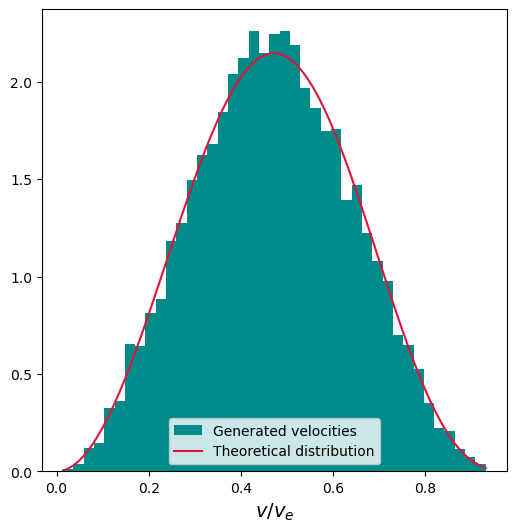

In [40]:
#Theoretical velocity distribution
norm_q = quad(lambda q: (1 - q**2)**(7/2) * q**2, 0, 1)[0]
v_d = lambda q: (1 - q**2)**(7/2) * q**2 / norm_q

#Escape velocity: v = q * v_e
v_e = np.sqrt(2 * M / np.sqrt(R_CM**2 + b**2)) 

#Plot the velocity distribution and dispersion
fig_vel, ax_vel = plt.subplots(1, 1, figsize=(6, 6))
    
ax_vel.hist((V_CM / v_e)[0, :], bins="fd", color="darkcyan", density=True, label="Generated velocities")    
ax_vel.plot(np.sort(V_CM / v_e)[0, :], v_d(np.sort(V_CM / v_e)[0, :]), color="crimson", label="Theoretical distribution")
ax_vel.set_xlabel("$v / v_e$", size=14)
ax_vel.legend()

if save_plots:
    plt.savefig(save_path + "/vel_hist.pdf")

### Conservation of energy and linear momentum

In [64]:
# Energy of the single particles at several given times
E_times = [0, int(len(time)/2), -1]
E_times_all = np.arange(0, len(time), 2)

#Kinetic and potential energy of every particle
K_i = 0.5 * masses * V_CM[E_times, :]**2 * M_phy * v_iu_phy**-2
U_i = np.zeros((len(E_times), N))

for U_idx, t in enumerate(E_times):
    for i in tqdm(range(N)):   
        dpos = pos_CM[t, :].copy()
        idx = np.concatenate((np.arange(0, i), np.arange(i + 1, N)))
        
        for j in range(3):
            dpos[idx, j] -= dpos[i, j]
            
        U_i[U_idx, idx] += -G_p * masses[idx] * masses[i] * M_phy**2 * r_phy**-1 * np.sqrt(dpos[idx, 0]**2 +
                                                          dpos[idx, 1]**2 +
                                                          dpos[idx, 2]**2)**-1
        
#Total energy of every particle
E_i = K_i + U_i

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1523.96it/s]


Total energy relative error = 0.345582


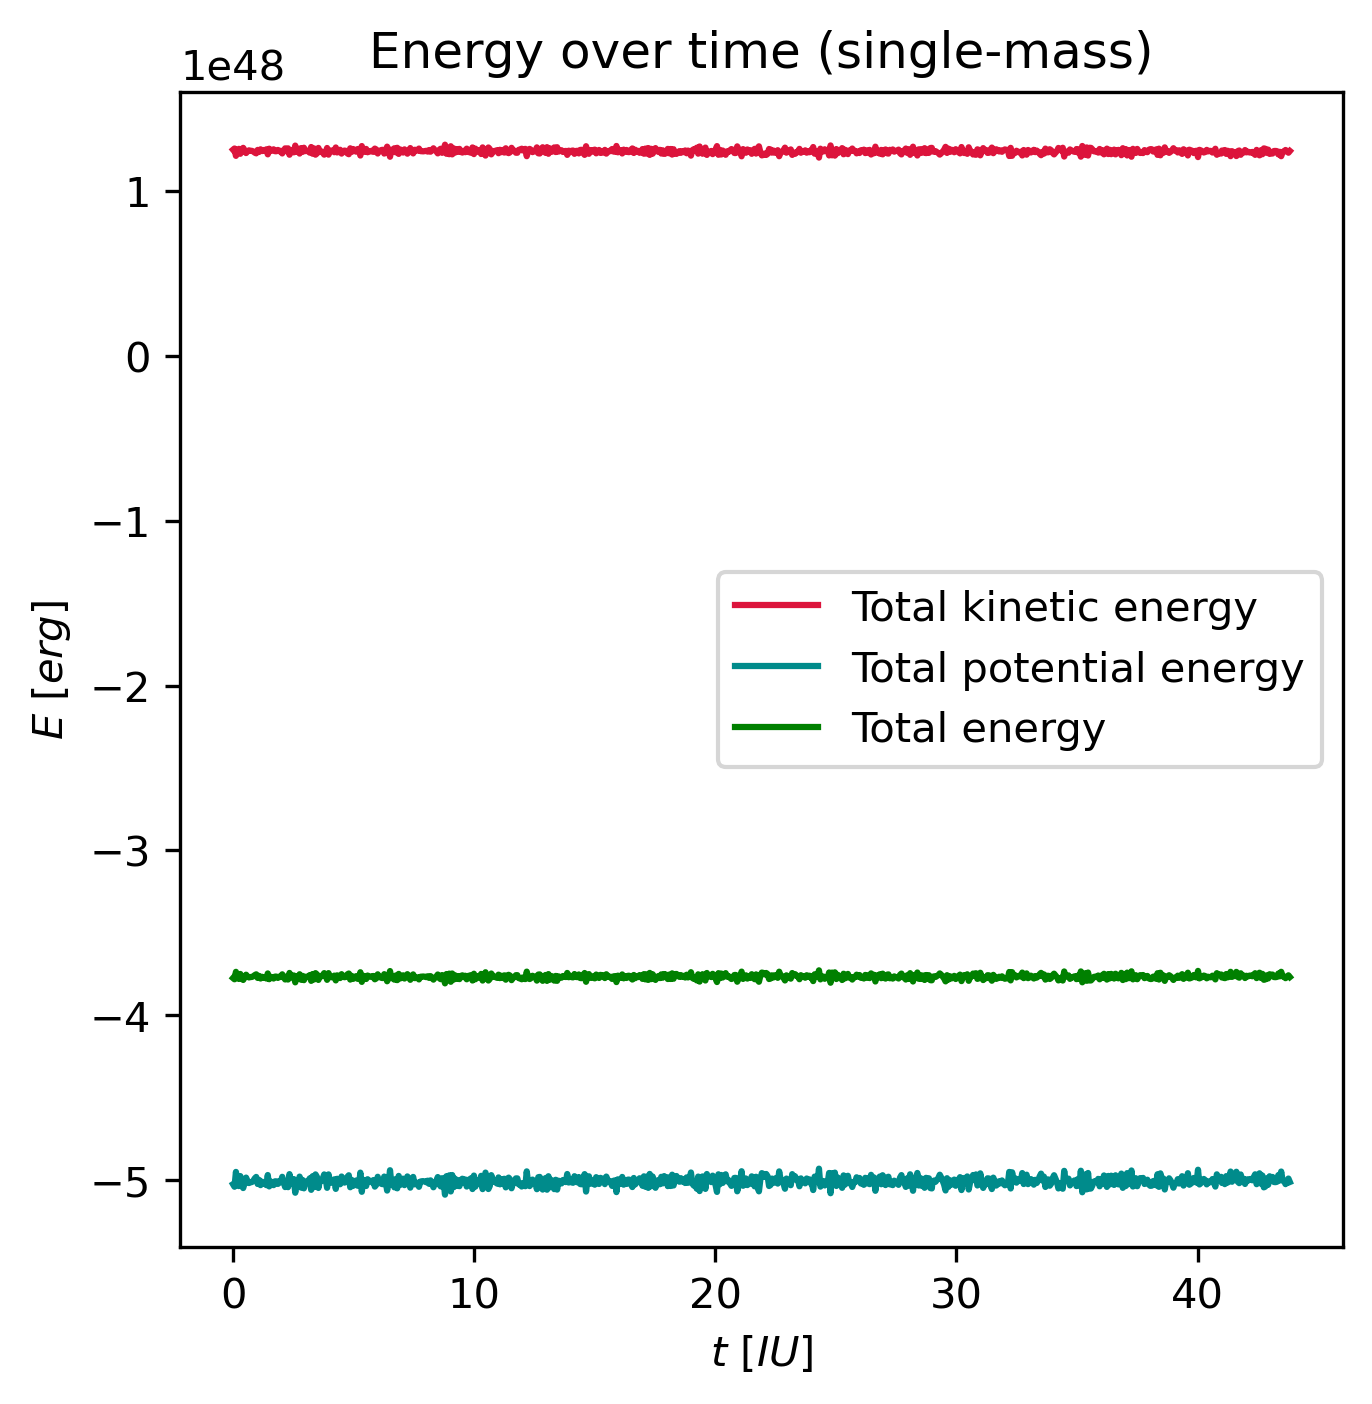

In [76]:
#Energy relative error
E_err = np.mean(np.abs((np.sum(E_i, axis=1) - np.sum(E_i[0]))/np.sum(E_i[0])) * 100)

print(f"Total energy relative error = {E_err:.6f}")

#Energy conservation plot
plt.figure(dpi=300, figsize=(5, 5))
plt.plot(time[E_times_all], np.sum(K_i_all, axis=1), color="crimson", label="Total kinetic energy")
plt.plot(time[E_times_all], np.sum(U_i_all, axis=1), color="darkcyan", label="Total potential energy")
plt.plot(time[E_times_all], np.sum(E_i_all, axis=1), color="green", label="Total energy")

if mass_populations:
    plt.title("Energy over time (double-mass)")
else:
    plt.title("Energy over time (single-mass)")
    
plt.xlabel("$t\ [IU]$")
plt.ylabel("$E\ [erg]$")
plt.legend()

if save_plots:
    plt.savefig(save_path + "en_cons.pdf")

Text(0.5, 0.03, '$t\\ [IU]$')

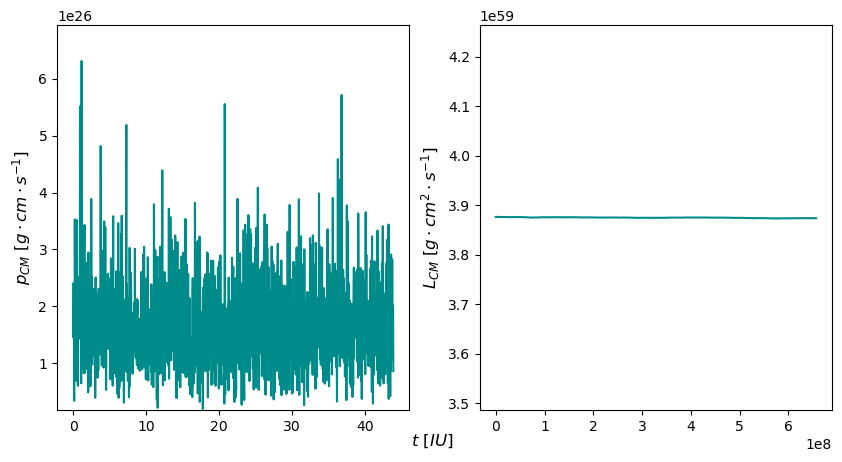

In [42]:
#Total linear momentum in the CM frame
p_tot_CM = M_phy * np.sqrt(np.sum(masses * vx_CM, axis=1)**2 + 
                              np.sum(masses * vy_CM, axis=1)**2 + 
                              np.sum(masses * vz_CM, axis=1)**2) / v_iu_phy

#Total angular momentum in the CM frame
L_tot_CM = M_phy * r_phy * v_iu_phy**-1 * np.sqrt(np.sum(y_CM * masses * vz_CM - z_CM * masses * vy_CM, axis=1)**2 + 
                                  np.sum(z_CM * masses * vx_CM - x_CM * masses * vz_CM, axis=1)**2 + 
                                  np.sum(x_CM * masses * vy_CM - y_CM * masses * vx_CM, axis=1)**2)

#Plot the linear momentum and angular momentum
fig_p, ax_p = plt.subplots(1, 2, figsize=(10, 5))

ax_p[0].plot(time, p_tot_CM, color="darkcyan")
ax_p[0].set_ylabel("$p_{CM}\ [g\cdot cm\cdot s^{-1}]$", size=12)
ax_p[0].set_ylim(0.9*np.min(p_tot_CM), 1.1*np.max(p_tot_CM))

ax_p[1].plot(time_yr, L_tot_CM, color="darkcyan")
ax_p[1].set_ylabel("$L_{CM}\ [g\cdot cm^{2}\cdot s^{-1}]$", size=12)
ax_p[1].set_ylim(0.9*np.min(L_tot_CM), 1.1*np.max(L_tot_CM))

fig_p.supxlabel("$t\ [IU]$", y=0.03)

### Compute density profile

In [49]:
#Function to divide the distribution in intervals
def DivideDistribution(rmin, rmax, r_grid_len, equal_volume=False):   
    if equal_volume:
        #Divide the sphere in volume elements, all with the same total volume
        volume = 4/3 * np.pi * rmax**3 / r_grid_len

        #Compute the radii of each volume element to form a grid of radii, up to an edge
        r_grid = np.zeros(r_grid_len)

        for i in range(r_grid_len - 1):
            r_grid[i + 1] = (3/4 / np.pi * volume + r_grid[i]**3)**(1/3)
            
        if r_grid[-1] < rmax:
            r_grid = np.append(r_grid, rmax)
            
    else:
        #Divide the sphere in volume elements, with constant radius intervals
        r_grid = np.linspace(rmin, rmax, r_grid_len)
            
        volume = 4/3 * np.pi * np.array([r_grid[i + 1]**3 - r_grid[i]**3 for i in range(len(r_grid) - 1)])

    return r_grid, volume

In [51]:
#Density and Poissonian error
rho = []
rho_err = []

#Divide the distribution in radius intervals
r_grid, volume = DivideDistribution(0, 5 * b, 45, False)

#Compute the density in each radius interval and the Poisson error
for t in range(len(time)):
    masses_binned = np.histogram(R_CM[t, :], bins=r_grid, weights=masses)[0]
    numbers_binned = np.histogram(R_CM[t, :], bins=r_grid)[0]
    
    rho.append(masses_binned / volume * M_phy * r_phy**-3)
    rho_err.append(np.sqrt(numbers_binned) * np.mean(masses) / volume * M_phy * r_phy**-3 )

rho = np.array(rho)
rho_err = np.array(rho_err)

In [ ]:
#Theoretical density profile
r_range = np.linspace(np.min(R_CM), 5 * b, len(r_grid))
rho_th = lambda r: 3 * M / (4 * np.pi* b**3) * (1 + r**2/b**2)**(-5/2) * M_phy * r_phy**-3

#Plot the density at each radius corresponding to the middle of a bin
bar_pos = np.diff(r_grid) / 2 + r_grid[:-1]

plt.figure(dpi=300)
plt.plot(bar_pos[:], rho[0], color="darkcyan", label=f"t = {time[0]:.2f} IU")
plt.plot(bar_pos[:], rho[int(len(time) / 2)], color="orange", label=f"t = {time[int(len(time) / 2)]:.2f} IU")
plt.plot(bar_pos[:], rho[-1], color="green", label=f"t = {time[-1]:.2f} IU")
plt.axvline(b, alpha=0.6, color="grey", linestyle="--", label="$r = b$")

plt.fill_between(bar_pos, 
                  rho[0, :] - rho_err[0, :], 
                  rho[0, :] + rho_err[0, :], alpha=0.3, color="darkcyan")

plt.fill_between(bar_pos, 
                  rho[int(len(time) / 2), :] - rho_err[int(len(time) / 2), :], 
                  rho[int(len(time) / 2), :] + rho_err[int(len(time) / 2), :], alpha=0.3, color="orange")

plt.fill_between(bar_pos, 
                  rho[-1, :] - rho_err[-1, :], 
                  rho[-1, :] + rho_err[-1, :], alpha=0.3, color="green")

plt.xlabel("$r\ [pc]$")
plt.ylabel("$\\rho(r)\ [g\ cm^{-3}]$")
plt.xlim(0, 3 * b)

if mass_populations:
    plt.title("Double-mass density profile")
else:
    plt.title("Single-mass density profile")
    
plt.legend(loc="upper right")

#Save figure
if save_plots:
    plt.savefig(save_path + "density_profile.pdf")

### Compute Lagrangian radii 

In [ ]:
#Function to compute the lagrangian radii
def RLag(R, mass, M_frac):
    r_idx = np.argsort(R, axis=1)
    M_cum = np.cumsum(np.array(np.ones(R.shape[-1]) * mass)[r_idx], axis=1)
    r_q = np.array([R[t, r_idx[t, np.where(M_cum[t, :] <= M_frac)[0][-1]]] for t in range(len(time))])

    return r_q


#Compute various Lagrangian radii
r_90 = RLag(R_CM, masses, 0.9*M)
r_80 = RLag(R_CM, masses, 0.8*M)
r_70 = RLag(R_CM, masses, 0.7*M)
r_50 = RLag(R_CM, masses, 0.5*M)
r_40 =  RLag(R_CM, masses, 0.4*M)
r_30 =  RLag(R_CM, masses, 0.3*M)
r_20 =  RLag(R_CM, masses, 0.2*M)
r_10 =  RLag(R_CM, masses, 0.1*M)
r_5 =  RLag(R_CM, masses, 0.05*M)
r_1 = RLag(R_CM, masses, 0.01*M)

#R_50 relative error
R50_err = np.mean(np.abs((r_50 - r_50[0])/r_50[0]) * 100)

print(f"R_50 relative error = {R50_err:.6f}")

#Lagrangian radii for heavy particles only
if mass_populations:
    #Use heavy particles only
    M_heavy = np.sum(masses[heavy_idx])

    r_90_heavy = RLag(R_CM[:, heavy_idx], masses[heavy_idx], 0.9*M_heavy)
    r_50_heavy = RLag(R_CM[:, heavy_idx], masses[heavy_idx], 0.5*M_heavy)
    r_10_heavy = RLag(R_CM[:, heavy_idx], masses[heavy_idx], 0.1*M_heavy)

    #Use light particles only
    M_light = np.sum(masses[light_idx])
    
    r_90_light = RLag(R_CM[:, light_idx], masses[light_idx], 0.9*M_light)
    r_50_light = RLag(R_CM[:, light_idx], masses[light_idx], 0.5*M_light)
    r_20_light = RLag(R_CM[:, light_idx], masses[light_idx], 0.2*M_light)
    r_10_light = RLag(R_CM[:, light_idx], masses[light_idx], 0.1*M_light)
    r_5_light = RLag(R_CM[:, light_idx], masses[light_idx], 0.05*M_light)
    r_1_light = RLag(R_CM[:, light_idx], masses[light_idx], 0.01*M_light)

In [ ]:
#Lagrangian radii plot
plt.figure(dpi=300, figsize=(6, 6))
plt.plot(time, r_50, label="$R_{50}$", color="darkcyan")
plt.plot(time, r_70, label="$R_{70}$", color="orange")
plt.plot(time, r_80, label="$R_{80}$", color="green")
plt.plot(time, r_90, label="$R_{90}$", color="crimson")
plt.axvline(t_rel * t_iu_phy, linestyle="--", color="black", alpha=0.5, label="Relaxation time")

if mass_populations:
    plt.title("High percentage Lagrangian radii (double-mass)")
else:
    plt.title("High percentage Lagrangian radii (single-mass)")
    
plt.xlabel("$t\ [IU]$")
plt.ylabel("$r\ [pc]$")
plt.legend()

if save_plots:
    plt.savefig(save_path + "lag_radii_long.pdf")

plt.figure(dpi=300)
plt.plot(time, r_40, label="$R_{40}$")
plt.plot(time, r_30, label="$R_{30}$")
plt.plot(time, r_20, label="$R_{20}$")
plt.axvline(t_rel * t_iu_phy, linestyle="--", color="black", alpha=0.5, label="Relaxation time")
plt.title("High percentage Lagrangian radii")
plt.xlabel("$t\ [IU]$")
plt.ylabel("$R\ [IU]$")
plt.legend()


#Low percent lagrangian radii only plot
plt.figure(dpi=300, figsize=(6, 6))
plt.plot(time, r_1, label="$R_{1}$", color="darkcyan")
plt.plot(time, r_5, label="$R_{5}$", color="orange")
plt.plot(time, r_10, label="$R_{10}$", color="green")
plt.plot(time, r_20, label="$R_{20}$", color="crimson")
plt.axvline(t_rel * t_iu_phy, linestyle="--", color="black", alpha=0.5, label="Relaxation time")

if mass_populations:
    plt.title("Low percentage Lagrangian radii (double-mass)")
else:
    plt.title("Low percentage Lagrangian radii (single-mass)")
    
plt.xlabel("$t\ [IU]$")
plt.ylabel("$r\ [pc]$")
plt.legend()

if save_plots:
    plt.savefig(save_path + "lag_radii_small.pdf")


#Lagrangian radii plot for massive particles only
if mass_populations:
    plt.figure(dpi=300, figsize=(6, 6))
    plt.plot(time, r_90_heavy, label="$R_{70}$", color="darkcyan")
    plt.plot(time, r_50_heavy, label="$R_{50}$", color="orange")
    plt.plot(time, r_10_heavy, label="$R_{10}$", color="green")
    plt.axvline(t_rel * t_iu_phy, linestyle="--", color="black", alpha=0.5, label="Relaxation time")
    plt.title("Lagrangian radii for heavy stars only")
    plt.xlabel("$t\ [IU]$")
    plt.ylabel("$r\ [pc]$")
    plt.title("Lagrangian radii (heavy particles only)")
    plt.legend()
    
    if save_plots:
        plt.savefig(save_path + "lag_radii_heavy.pdf")


#Lagrangian radii plot for light particles only
if mass_populations:
    plt.figure(dpi=300)
    plt.plot(time, r_20_light, label="$R_{20}$")
    plt.plot(time, r_10_light, label="$R_{10}$")
    plt.plot(time, r_5_light, label="$R_{5}$")
    plt.plot(time, r_1_light, label="$R_{1}$")
    plt.axvline(t_rel * t_iu_phy, linestyle="--", color="black", alpha=0.5, label="Relaxation time")
    plt.xlabel("$t\ [IU]$")
    plt.ylabel("$R\ [IU]$")
    plt.title("Light particles only")
    plt.legend()


#Mean radius over time for massive and light particles
plt.figure()
plt.plot(time_yr, np.mean(R_CM[:, light_idx], axis=1), label="Light")

if mass_populations:
    plt.plot(time_yr, np.mean(R_CM[:, heavy_idx], axis=1), label="Heavy")
    
plt.axvline(t_rel, linestyle="--", color="black", alpha=0.5, label="Relaxation time")
plt.xlabel("$t\ [yr]$")
plt.ylabel("$R_{mean}\ [pc]$")
plt.legend()

#Number of particles inside a radius b over time
plt.figure(dpi=300)
plt.plot(time, np.sum(R_CM[:, light_idx] < b, axis=1), color="darkcyan")

if mass_populations:
    plt.plot(time, np.sum(R_CM[:, heavy_idx] < b, axis=1), label="Heavy")
    
plt.axvline(t_rel * t_iu_phy, linestyle="--", color="black", alpha=0.5, label="Relaxation time")
plt.title("Number of particles inside b")
plt.xlabel("$t\ [IU]$")
plt.ylabel("$N_{<b}$")
plt.legend()

#Radii of heavy particles only
if mass_populations:
    plt.figure()
    plt.plot(time_yr, R_CM[:, heavy_idx], alpha=0.1)
    plt.plot(time_yr, np.mean(R_CM[:, heavy_idx], axis=1), color="black", label="Mean radius")
    plt.axvline(t_rel, linestyle="--", color="black", alpha=0.5, label="Relaxation time")
    plt.xlabel("$t\ [yr]$")
    plt.ylabel("$R\ [r_{phy}]$")
    plt.legend()

In [ ]:
#MS Lagrangian radii in the same plot

if mass_populations:
    fig_l, ax_l = plt.subplots(1, 3, figsize=(18, 6), dpi=300)

    #Low percentage radii
    ax_l[0].plot(time, r_1, label="$R_{1}$", color="darkcyan")
    ax_l[0].plot(time, r_5, label="$R_{5}$", color="orange")
    ax_l[0].plot(time, r_10, label="$R_{10}$", color="green")
    ax_l[0].plot(time, r_20, label="$R_{20}$", color="crimson")
    ax_l[0].axvline(t_rel * t_iu_phy, linestyle="--", color="black", alpha=0.5, label="Relaxation time")
    ax_l[0].set_title("Low percentage Lagrangian radii (double-mass)")
    ax_l[0].legend()

    #High percentage radii
    ax_l[1].plot(time, r_50, label="$R_{50}$", color="darkcyan")
    ax_l[1].plot(time, r_70, label="$R_{70}$", color="orange")
    ax_l[1].plot(time, r_80, label="$R_{80}$", color="green")
    ax_l[1].plot(time, r_90, label="$R_{90}$", color="crimson")
    ax_l[1].axvline(t_rel * t_iu_phy, linestyle="--", color="black", alpha=0.5, label="Relaxation time")
    ax_l[1].set_title("High percentage Lagrangian radii (double-mass)")
    ax_l[1].legend()

    #Heavy particles only radii
    ax_l[2].plot(time, r_90_heavy, label="$R_{70}$", color="darkcyan")
    ax_l[2].plot(time, r_50_heavy, label="$R_{50}$", color="orange")
    ax_l[2].plot(time, r_10_heavy, label="$R_{10}$", color="green")
    ax_l[2].axvline(t_rel * t_iu_phy, linestyle="--", color="black", alpha=0.5, label="Relaxation time")
    ax_l[2].set_title("Lagrangian radii (heavy stars only)")
    ax_l[2].legend()
    
    fig_l.supxlabel("$t\ [IU]$", y=0.03)
    fig_l.supylabel("$r\ [pc]$", x=0.09)

    if save_plots:
        plt.savefig(save_plots + "all_lag_radii.pdf")

In [ ]:
#Plot the number of particles inside a lagrangian radius
N_lag0 = np.sum(R_CM <= r_1[0], axis=1) #Particles inside r_1 at initial time
N_lagf = np.sum(R_CM <= r_1[-1], axis=1) #Particles inside r_1 at final time

plt.figure(dpi=300)
plt.plot(time, N_lag0, label="$R_1(t = 0\ IU)$", color="darkcyan")
plt.plot(time, N_lagf, label="$R_1(t = " + f"{time[-1]:.2f}" + "\ IU)$", color="orange")
plt.axvline(t_rel * t_iu_phy, linestyle="--", color="black", alpha=0.5, label="Relaxation time")
plt.title("Number of particles inside $R_1$")
plt.xlabel("$t\ [IU]$")
plt.ylabel("$N_{\leq R_1}$", size=11)
plt.legend()

if save_plot:
    plt.savefig(save_path + "number_R1.pdf")

### Compute potential profile

In [56]:
#Compute the potential on a r_grid on the equatorial plane (phi = theta = 0)
#For spherical symmetry this is the same potential for every other phi and theta
V = np.zeros((len(time), len(r_grid)))

for t in range(len(time)):
    for r in range(len(r_grid)):
        V[t, r] = -G_p * M_phy * r_phy**-1 * np.sum(masses * np.sqrt((x_CM[t, :] - r_grid[r])**2 + 
                                                    y_CM[t, :]**2 + z_CM[t, :]**2)**-1)

### Energy distribution 

In [ ]:
#Particle energy distribution
plt.figure()

for E, idx in zip([E_i[0], E_i[int(len(E_times) / 2)], E_i[-1]], [E_times[0], E_times[int(len(E_times) / 2)], E_times[-1]]):
    plt.hist(E, bins="fd", histtype="step", label=f"$t = ${time[idx]:.2f} $IU$")

if mass_populations:
    plt.title("Particle energy distribution (double-mass)")
else:
    plt.title("Particle energy distribution (single-mass)")
    
plt.xlabel("$E_{particle}\ [erg]$")
plt.legend()

if save_plots:
    plt.savefig(save_path + "energy_hist.pdf")

In [ ]:
#Energy histograms for heavy and light particles
if mass_populations:
    #Light particles histogram
    plt.figure()

    for E, idx in zip([E_i[0], E_i[int(len(E_times) / 2)], E_i[-1]], [E_times[0], E_times[int(len(E_times) / 2)], E_times[-1]]):
        plt.hist(E[light_idx], bins="fd", histtype="step", label=f"$t = ${time[idx]:.2f} $IU$")

    plt.title("Light stars energy distribution")
    plt.xlabel("$E_{particle}\ [erg]$")
    plt.legend()

    if save_plots:
        plt.savefig(save_path + "energy_hist_light.pdf")

    #Heavy particles histogram
    plt.figure()

    for E, idx in zip([E_i[0], E_i[int(len(E_times)/2)], E_i[-1]], [E_times[0], E_times[int(len(E_times) / 2)], E_times[-1]]):
        plt.hist(E[heavy_idx], bins="fd", histtype="step", label=f"$t = ${time[idx]:.2f} $IU$")

    plt.title("Heavy stars energy distribution")
    plt.xlabel("$E_{particle}\ [erg]$")
    plt.legend()

    if save_plots:
        plt.savefig(save_path + "energy_hist_heavy.pdf")

In [ ]:
#Potential energy distribution
plt.figure()

for E, idx in zip([U_i[0], U_i[int(len(E_times) / 2)], U_i[-1]], [E_times[0], E_times[int(len(E_times) / 2)], E_times[-1]]):
    plt.hist(E, bins="fd", histtype="step", label=f"$t = ${time[idx]:.2f} $IU$")

if mass_populations:
    plt.title("Potential energy distribution (double-mass)")
else:
    plt.title("Potential energy distribution (single-mass)")
    
plt.xlabel("$E_{particle}\ [erg]$")
plt.legend()


#Kinetic energy distribution
plt.figure()

for E, idx in zip([K_i[0], K_i[int(len(E_times) / 2)], K_i[-1]], [E_times[0], E_times[int(len(E_times) / 2)], E_times[-1]]):
    plt.hist(E, bins="fd", histtype="step", label=f"$t = ${time[idx]:.2f} $IU$")

if mass_populations:
    plt.title("Kinetic energy distribution (double-mass)")
else:
    plt.title("Kinetic energy distribution (single-mass)")
    
plt.xlabel("$E_{particle}\ [erg]$")
plt.legend()


#Final energies
#High final energy particle distribution
cond_out = np.logical_and(E_i[-1, :] >= -3e44, R_CM[0, :] <= 1000)

plt.figure()
plt.hist(np.log10(R_CM[0, cond_out]), bins="fd", histtype="step", label=f"$t = ${time[0]:.2f} $IU$")
plt.hist(np.log10(R_CM[int(len(time)/2), cond_out]), bins="fd", histtype="step", label=f"$t = ${time[int(len(time)/2)]:.2f} $IU$")
plt.hist(np.log10(R_CM[-1, cond_out]), bins="fd", histtype="step", label=f"$t = ${time[-1]:.2f} $IU$")
plt.axvline(np.log10(r_50[0]), linestyle="--", color="black", alpha=0.5, label="$R_{50} = 1.3b$")
plt.xlabel("$\log{r/pc}$")
plt.title("Stars with final energy $E_f \geq -0.3 \\times 10^{45}\ erg$")
plt.legend()

if save_plots:
    plt.savefig(save_path + "en_distr_out.pdf")


#Low final energy particle distribution
cond_in = np.logical_and(E_i[-1, :] < -6e44, R_CM[0, :] < 1000)

plt.figure()
plt.hist(np.log10(R_CM[0, cond_in]), bins="fd", histtype="step", label=f"$t = ${time[0]:.2f} $IU$")
plt.hist(np.log10(R_CM[int(len(time)/2), cond_in]), bins="fd", histtype="step", label=f"$t = ${time[int(len(time)/2)]:.2f} $IU$")
plt.hist(np.log10(R_CM[-1, cond_in]), bins="fd", histtype="step", label=f"$t = ${time[-1]:.2f} $IU$")
plt.axvline(np.log10(r_50[-1]), linestyle="--", color="black", alpha=0.5, label="$R_{50} = 1.3b$")
plt.xlabel("$\log{r/pc}$")
plt.title("Stars with final energy $E_f < -0.6 \\times 10^{45}\ erg$")
plt.legend()

if save_plots:
    plt.savefig("Report/en_distr_in.pdf")

### Escaped particles

In [ ]:
#Plot the orbits of the escaped particles

#Find the orbits of the particles with positive energy
idx_escaped = np.where(E_i[-1, :] >= 0)[0]

if len(idx_escaped) > 0:
    R_escaped = R_CM[:, idx_escaped]
    
    #Compute the eccentricity of the orbits
    ecc = np.ones(len(idx_escaped))
    
    for i in range(len(idx_escaped)):
        R_esc_max_idx = np.array(argrelmax(R_escaped[:, i])[0])
        R_esc_min_idx = np.array(argrelmin(R_escaped[:, i])[0])
        R_esc_max_points = time_yr[R_esc_max_idx]
        R_esc_min_points = time_yr[R_esc_min_idx]
        
        apo = R_escaped[R_esc_max_idx, i][0]
        per = R_escaped[R_esc_min_idx, i][0]
        ecc[i] = (apo - per) / (apo + per)
        

    #Plot escaped particles orbits
    plt.figure()
    
    for i, idx in enumerate(idx_escaped):
        t_escape = np.array([time[E_times_all][np.where(E_i_all[:, idx] >= 0)[0][0]] for idx in idx_escaped])
        plot = plt.plot(time, R_escaped[:, i], label="$\\varepsilon_0 =$" + f"{ecc[i]: .2f}")
        plt.axvline(t_escape[i], linestyle="--", color=plot[0].get_color(), label="$t_{escape} = $" + f"{t_escape[i]:.2f}" + "$\ IU$")
            
    if mass_populations:
        plt.title("Escaped particles (double-mass)")
    else:
        plt.title("Escaped particles (single-mass)")
        
    plt.xlabel("$t\ [IU]$")
    plt.ylabel("$r\ [pc]$")
    plt.legend()
    
    if save_plots:
        plt.savefig(save_path + "escaped.pdf")

In [ ]:
#3D escaped particles orbits plot
if len(idx_escaped) > 0:
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    
    for i in idx_escaped:
        plt.plot(x_CM[:, i], y_CM[:, i], z_CM[:, i])